In [4]:
rating_df = pd.read_csv('data/ratings.csv')

print(rating_df.shape)
rating_df.head(3)

(25000095, 4)


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828


In [2]:
rating_df.rating.describe()

count    2.500010e+07
mean     3.533854e+00
std      1.060744e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

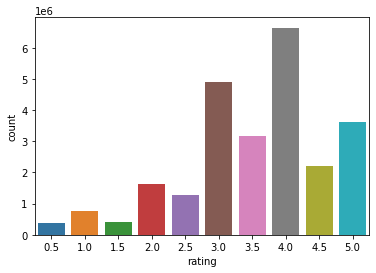

In [3]:
sns.countplot(rating_df.rating);

In [4]:
# 유저 수는 약 162000명, 영화 수는 약 59000개 이다.
print(f"Users : {rating_df.userId.nunique()}")
print(f"Movies : {rating_df.movieId.nunique()}")

Users : 162541
Movies : 59047


In [5]:
# 한 유저가 같은 영화에 대해 두 번 이상 평점을 매긴 경우는 존재하지 않는다.
rating_df.groupby(['userId', 'movieId']).size().value_counts()

1    25000095
dtype: int64

In [6]:
# 해당 데이터는 한 유저가 최소 20개에서부터 최대 약 32000개의 영화에 대해 평점을 매긴 데이터이다.
rating_df.groupby('userId')['movieId'].count().sort_values()

userId
56219        20
87801        20
129589       20
57943        20
129586       20
          ...  
20055      7488
33844      7919
137293     8913
80974      9178
72315     32202
Name: movieId, Length: 162541, dtype: int64

In [7]:
# 한 명의 유저에게 평가받은 영화는 10298개, 두 명의 유저에게 평가받은 영화는 7633개 ... 로 이루어져 있다.
rating_df.groupby('movieId')['userId'].count().value_counts()

1        10298
2         7633
3         4923
4         3473
5         2513
         ...  
4527         1
2508         1
6638         1
10760        1
14329        1
Name: userId, Length: 3820, dtype: int64

---

---

# 상품 중심 협업 필터링

In [2]:
from tqdm import tqdm

from modules.module import *

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

## 1

In [5]:
filtered_df = filtering_df(rating_df, 100, 50)

del rating_df

필터링 전 데이터 수 :25000095
필터링 후 데이터 수 :22488390


In [6]:
# Train, Test Dataset Split
train_df, test_df = train_test_split(filtered_df, random_state=13)

del filtered_df

In [7]:
pivot_df = trans_interaction_matrix(train_df, impute='mean')

print(pivot_df.shape)
pivot_df.head(2)

Return userId-movieId Matrix
(101074, 10291)


movieId,1,2,3,4,5,6,7,8,9,10,...,202103,202393,202429,202439,203222,203519,204352,204542,204698,205383
userId,,,,,,,,,,,,,,,,,,,,,
1,3.923077,3.923077,3.923077,3.923077,3.923077,3.923077,3.923077,3.923077,3.923077,3.923077,...,3.923077,3.923077,3.923077,3.923077,3.923077,3.923077,3.923077,3.923077,3.923077,3.923077
2,3.500000,3.660839,3.660839,3.660839,3.660839,3.660839,3.660839,3.660839,3.660839,3.660839,...,3.660839,3.660839,3.660839,3.660839,3.660839,3.660839,3.660839,3.660839,3.660839,3.660839


In [8]:
# 유저-영화 행렬을 영화-유저 행렬로 전치
pivot_df_T = pivot_df.T

# 영화 인덱스 추출
movie_indices = pivot_df_T.index

In [9]:
# 유사 영화 수 추출
n_similar_movies = 10

# 영화-영화 코사인 유사도 행렬 추출
movie_cosine_matrix = cosine_similarity(pivot_df_T, pivot_df_T)

In [15]:
%%time

rating_prediction_dfs = []
for movie_id in test_df['movieId'].unique():
    # 해당 movie_id의 n개의 유사 movie_id 및 그에 대한 유사도 추출
    n_similarities = search_n_similarities(movie_cosine_matrix, movie_id, movie_indices, n_similar_movies)

    # Test Dataset에서 해당 영화에 평점을 매긴 유저들 추출
    test_users = test_df.loc[test_df['movieId'] == movie_id, 'userId']
    
    # 영화-유저 인터랙션 행렬에서 유사 영화 리스트에 대해 test_users가 평점을 매긴 행렬 추출
    n_ratings = pivot_df_T.loc[n_similarities.index, test_users]
    
    # 추출한 영화-유저 행렬과 유사도 벡터의 가중 평균을 통해 해당 영화에 대해 각 test_user의 예측 평점 도출
    weighted_n_ratings = n_ratings.multiply(n_similarities, axis='index')
    scores = weighted_n_ratings.sum(axis=0) / n_similarities.sum()
    
    # 예측 평점 데이터프레임 생성 후 전체 예측 데이터프레임에 추가
    scores_df = scores.rename('prediction').reset_index().assign(movie_id=movie_id)
    rating_prediction_dfs.append(scores_df)

CPU times: user 15min 3s, sys: 1min 6s, total: 16min 10s
Wall time: 4min 32s


In [19]:
movie_pred_df = pd.concat(rating_prediction_dfs).set_index(['userId', 'movie_id'])
movie_pred_df = test_df.rename({'movieId': 'movie_id'}, axis=1).set_index(['userId', 'movie_id']).join(movie_pred_df)
movie_pred_df.head(3)

,,rating,timestamp,prediction
userId,movie_id,,,
48065,160,3.0,864946735,3.647059
15290,1394,4.0,1111616642,3.635613
128110,4799,2.5,1107336422,3.286269


In [21]:
eval_model(movie_pred_df, 'item')

RMSE of recommendation by item-item collaborative filtering: 0.9473424478079131


## 2 : 개선된 모델 로직
- 코사인 유사도 계산을 위해 결측값을 각 유저의 평균 평점으로 대체하였음
    - 그렇기에 어떤 영화에 대한 유저들의 예측 평점을 계산할 때, 시청하지 않은 영화에 대한 평점은 유저의 평균 평점을 통해 가중 평균을 함
    - 평점을 예측할 때, 유저가 시청하지 않은 영화는 가중 평균에 개입이 안되게 모델 개선
- 몇 개의 샘플데이터로 진행한 결과, 개선 가능성이 보여 모델링을 진행하였음

In [10]:
# 결측값을 0으로 채운 인터랙션 행렬 생성
zero_imputed_df = trans_interaction_matrix(train_df, impute='zero')

# 유저-상품 행렬을 상품-유저 행렬로 전치
zero_imputed_df = zero_imputed_df.T

print(zero_imputed_df.shape)
zero_imputed_df.head(2)

Return userId-movieId Matrix
(10291, 101074)


userId,1,2,3,4,5,8,9,10,12,13,...,162530,162532,162533,162534,162535,162536,162537,162538,162540,162541
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,3.5,4.0,3.0,0.0,0.0,0.0,3.5,0.0,4.0,...,0.0,0.0,4.5,4.0,0.0,0.0,0.0,2.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,2.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
%%time

test_length = int(test_df.movieId.nunique())

ratings_prediction_dfs = []
for num, movie_id in enumerate(test_df.movieId.unique()):
    if num in np.linspace(0, test_length, 11).astype(int).tolist()[1:]:
        print(f"Completed {int(np.round((num / test_length), 1) * 100)}%")
        
    n_similarities = search_n_similarities(movie_cosine_matrix, movie_id, movie_indices, n_similar_movies)

    test_users = test_df.loc[test_df['movieId'] == movie_id, 'userId']
    
    weighted_zero_n_ratings = zero_imputed_df.loc[n_similarities.index, test_users].multiply(n_similarities, axis=0)

    weighted_mean_n_ratings = pivot_df_T.loc[n_similarities.index, test_users].multiply(n_similarities, axis=0)
    scores = weighted_mean_n_ratings.sum(axis=0) / n_similarities.sum()
    
    score_per_user = predict_target_scores(weighted_zero_n_ratings, scores, n_similarities, 'user_id')
    
    score_df = pd.DataFrame(score_per_user).assign(movie_id=movie_id)
    ratings_prediction_dfs.append(score_df)

Completed 10%
Completed 20%
Completed 30%
Completed 40%
Completed 50%
Completed 60%
Completed 70%
Completed 80%
Completed 90%
CPU times: user 31min 58s, sys: 2h 3min 39s, total: 2h 35min 38s
Wall time: 3h 43min 4s


In [16]:
movie_pred_df = pd.concat(ratings_prediction_dfs).set_index(['user_id', 'movie_id'])
movie_pred_df = test_df.rename({'userId': 'user_id', 'movieId': 'movie_id'}, axis=1).set_index(['user_id', 'movie_id']).join(movie_pred_df)
movie_pred_df.head(3)

,,rating,timestamp,prediction
user_id,movie_id,,,
48065,160,3.0,864946735,3.647059
15290,1394,4.0,1111616642,3.635613
128110,4799,2.5,1107336422,3.286269


In [19]:
eval_model(movie_pred_df, 'item')

RMSE of recommendation by item-item collaborative filtering: 0.9494665308953931


---

---

---

# 유저 중심 협업 필터링

In [1]:
from tqdm import tqdm

from modules.module import *

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
rating_df = pd.read_csv('data/ratings.csv')

filtered_df = filtering_df(rating_df, 100, 200)

del rating_df

필터링 전 데이터 수 :25000095
필터링 후 데이터 수 :15558026


In [5]:
# Train, Test Dataset Split
train_df, test_df = train_test_split(filtered_df, test_size=0.15, random_state=13)

del filtered_df

In [6]:
pivot_df = trans_interaction_matrix(train_df, impute='mean')

print(pivot_df.shape)
pivot_df.head(2)

Return userId-movieId Matrix
(32848, 10291)


movieId,1,2,3,4,5,6,7,8,9,10,...,202103,202393,202429,202439,203222,203519,204352,204542,204698,205383
userId,,,,,,,,,,,,,,,,,,,,,
3,4.0,3.690519,3.690519,3.690519,3.690519,3.690519,3.690519,3.690519,3.690519,3.690519,...,3.690519,3.690519,3.690519,3.690519,3.690519,3.690519,3.690519,3.690519,3.690519,3.690519
4,3.0,3.359223,3.359223,3.359223,3.359223,3.359223,3.359223,3.359223,3.359223,3.359223,...,3.359223,3.359223,3.359223,3.359223,3.359223,2.500000,3.359223,3.359223,3.359223,3.359223


In [7]:
# 유저 인덱스 추출
user_indices = pivot_df.index

# 이웃 유저 n명 설정
n_similar_users = 10

# 유저-유저 코사인 유사도 행렬 생성
user_cosine_matrix = cosine_similarity(pivot_df, pivot_df)

In [25]:
users_score_dfs = []
for user_id in tqdm(test_df['userId'].unique()):
    n_similarities = search_n_similarities(user_cosine_matrix, user_id, user_indices, n_similar_users)
    
    test_movies = test_df.loc[test_df['userId'] == user_id, 'movieId']
    
    n_ratings = pivot_df.loc[n_similarities.index, test_movies]
    weighted_n_ratings = n_ratings.multiply(n_similarities, axis=0)
    
    scores = weighted_n_ratings.sum(axis=0) / n_similarities.sum()
    
    score_df = scores.rename('prediction').reset_index().assign(user_id=user_id)
    users_score_dfs.append(score_df)

100%|██████████| 32848/32848 [11:11<00:00, 48.89it/s]


In [27]:
user_pred_df = (
    pd.concat(users_score_dfs)
    .rename({'movieId': 'movie_id'}, axis=1)
    .set_index(['user_id', 'movie_id'])
)

user_pred_df = (
    test_df.rename({'userId': 'user_id', 'movieId': 'movie_id'}, axis=1)
    .set_index(['user_id', 'movie_id'])
    .join(user_pred_df)
)
user_pred_df.head(3)

,,rating,timestamp,prediction
user_id,movie_id,,,
101305,102903,5.0,1467221425,4.849999
999,377,3.0,1039756275,4.999476
122954,924,5.0,1026857765,4.999473


In [28]:
eval_model(user_pred_df, 'user')

RMSE of recommendation by user-user collaborative filtering: 1.548094379130262


---

## 2 : 개선 유저 중심 협업 필터링 로직
- 영화 중심 협업 필터링 모델의 개선 아이디어와 동일하게 진행

In [10]:
zero_imputed_df = trans_interaction_matrix(train_df, impute='zero')

print(zero_imputed_df.shape)
zero_imputed_df.head(2)

Return userId-movieId Matrix
(32848, 10291)


movieId,1,2,3,4,5,6,7,8,9,10,...,202103,202393,202429,202439,203222,203519,204352,204542,204698,205383
userId,,,,,,,,,,,,,,,,,,,,,
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0


In [26]:
ratings_prediction_dfs = []
for user_id in tqdm(test_df.userId.unique()):
    n_similarities = search_n_similarities(user_cosine_matrix, user_id, user_indices, n_similar_users)
    
    test_movies = test_df.loc[test_df['userId'] == user_id, 'movieId']
    
    weighted_zero_n_ratings = zero_imputed_df.loc[n_similarities.index, test_movies].multiply(n_similarities, axis=0)
    
    weighted_mean_n_ratings = pivot_df.loc[n_similarities.index, test_movies].multiply(n_similarities, axis=0)
    scores = weighted_mean_n_ratings.sum(axis=0) / n_similarities.sum()
    
    score_per_movie = predict_target_scores(weighted_zero_n_ratings, scores, n_similarities, 'movie_id')
    
    score_df = pd.DataFrame(score_per_movie).assign(user_id=user_id)
    ratings_prediction_dfs.append(score_df)

100%|██████████| 32848/32848 [16:47<00:00, 32.60it/s]


In [27]:
user_pred_df = (
    pd.concat(ratings_prediction_dfs)
    .rename({'movieId': 'movie_id'}, axis=1)
    .set_index(['user_id', 'movie_id'])
)

user_pred_df = (
    test_df.rename({'userId': 'user_id', 'movieId': 'movie_id'}, axis=1)
    .set_index(['user_id', 'movie_id'])
    .join(user_pred_df)
)
user_pred_df.head(3)

,,rating,timestamp,prediction
user_id,movie_id,,,
101305,102903,5.0,1467221425,4.624999
999,377,3.0,1039756275,4.999476
122954,924,5.0,1026857765,5.000000


In [28]:
eval_model(user_pred_df, 'user')

RMSE of recommendation by user-user collaborative filtering: 1.5311085952941947


## 3 : 개선 유저 중심 협업 필터링 로직

### 코사인 유사도 > 자카드 유사도
- 자카드 유사도는 보통 Sparse한 데이터에서 사용
    - 평점을 기준으로 라벨링 진행
    - 평점 4 이상 : 1 / 평점 4 미만 : -1 / 시청안함 : 0 (평점을 긍정, 부정으로 변환)

<br/>

- 유저-영화 긍/부정 인터랙션 행렬에 대해 자카드 유사도 행렬 생성
    - 특정 유저와 모든 유저간의 유사도 값 계산
        - 둘 중 하나라도 영화를 안 봄 : 0
        - 둘 모두 긍정으로 평가 : 1 (1x1)
        - 둘 모두 부정으로 평가 : 1 (-1x-1)
        - 둘이 평가를 다르게 함 : -1 (-1x1 or 1x-1)
        - 두 유저에 대해 10291개 영화에 대한 평점 분포로 유사도를 계산한 값이 하나의 스칼라 값이 됨
            - 두 유저가 i, j라면 추출된 값은 자카드 유사도 행렬 (i, j) 위치에 들어감

### 자카드 유사도 1 : 특정 유저 기준
- 자카드 유사도의 분모 즉, 비교되는 두 대상간의 합집합을 첫번째 유저의 영화 집합으로 가정
    - 가정 이유 : 첫번째 유저와 가장 유사한 유저들을 찾기 위해
        - 첫번째 유저의 영화 집합 안에서 두 유저의 영화 교집합을 구하기에
        - 또한 합집합이 고정되어 있기에, 다른 유저들과의 유사도를 좀 더 상대적으로 추출 가능 
    - 이로 인해 발생 가능한 이슈 : 비교되는 두번째 유저가 시청한 영화가 많을수록 유사도가 높아질 가능성 존재
- 스칼라 값이 들어가 있는 자카드 유사도 행렬을 각 유저의 영화 집합(자카드 유사도의 합집합)으로 나눔

In [2]:
rating_df = pd.read_csv('data/ratings.csv')

filtered_df = filtering_df(rating_df, 100, 200).drop('timestamp', axis=1)

del rating_df

필터링 전 데이터 수 :25000095
필터링 후 데이터 수 :15558026


In [3]:
# 긍정, 부정을 표현하는 변수 생성
filtered_df['bool_rating'] = filtered_df['rating'].map(lambda x: 1 if x >= 4.0 else -1)

print(filtered_df.shape)
filtered_df.head(2)

(15558026, 4)


,userId,movieId,rating,bool_rating
254,3,1,4.0,1
255,3,29,4.5,1


In [4]:
# 결측값을 0으로 대체하여 시청안함을 0으로 만듦
jacc_pivot_df = (
    pd.pivot_table(data=filtered_df, index='userId', columns='movieId', values='bool_rating')
).fillna(0)

jacc_pivot_df.head(2)

movieId,1,2,3,4,5,6,7,8,9,10,...,202103,202393,202429,202439,203222,203519,204352,204542,204698,205383
userId,,,,,,,,,,,,,,,,,,,,,
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0


### 스칼라 값이 들어간 자카드 유사도 행렬 생성
- 유저-영화 행렬의 행렬곱 진행

In [5]:
jaccard_matrix = jacc_pivot_df.values @ jacc_pivot_df.T.values
jaccard_matrix

array([[654.,  18.,  34., ...,  26.,  48.,  -2.],
       [ 18., 239.,  -4., ...,   5.,  12.,  21.],
       [ 34.,  -4., 731., ...,  53.,  35.,  24.],
       ...,
       [ 26.,   5.,  53., ..., 381.,  21.,   8.],
       [ 48.,  12.,  35., ...,  21., 367.,  30.],
       [ -2.,  21.,  24., ...,   8.,  30., 475.]])

#### 비교되는 첫 번째 유저의 영화집합을 합집합으로 하여 자카드 유사도 행렬 생성
- 각 행의 최대값은 자기 자신에 대한 유사도 값이므로 해당 유저가 시청한 영화 수라고 할 수 있음
- 따라서 각 행의 최대값을 분모로하여 나눔

In [6]:
jaccard_similarity = jaccard_matrix / np.max(jaccard_matrix, axis=0)
jaccard_similarity

array([[ 1.        ,  0.07531381,  0.04651163, ...,  0.06824147,
         0.13079019, -0.00421053],
       [ 0.02752294,  1.        , -0.00547196, ...,  0.01312336,
         0.03269755,  0.04421053],
       [ 0.05198777, -0.0167364 ,  1.        , ...,  0.13910761,
         0.09536785,  0.05052632],
       ...,
       [ 0.03975535,  0.0209205 ,  0.07250342, ...,  1.        ,
         0.05722071,  0.01684211],
       [ 0.0733945 ,  0.05020921,  0.04787962, ...,  0.05511811,
         1.        ,  0.06315789],
       [-0.0030581 ,  0.08786611,  0.03283174, ...,  0.02099738,
         0.08174387,  1.        ]])

### 모델링 진행

In [7]:
# Train, Test Dataset Split
train_df, test_df = train_test_split(filtered_df, random_state=13)

In [8]:
pivot_df = trans_interaction_matrix(train_df, impute='mean')
zero_imputed_df = trans_interaction_matrix(train_df, impute='zero')

Return userId-movieId Matrix
Return userId-movieId Matrix


In [9]:
user_indices = jacc_pivot_df.index

n_similar_users = 10

In [10]:
ratings_prediction_dfs = []
for user_id in tqdm(test_df.userId.unique()):
    n_similarities = search_n_similarities(jaccard_similarity, user_id, user_indices, n_similar_users)
    
    test_movies = test_df.loc[test_df['userId'] == user_id, 'movieId']
    
    weighted_zero_n_ratings = zero_imputed_df.loc[n_similarities.index, test_movies].multiply(n_similarities, axis=0)

    weighted_mean_n_ratings = pivot_df.loc[n_similarities.index, test_movies].multiply(n_similarities, axis=0)
    scores = weighted_mean_n_ratings.sum(axis=0) / n_similarities.sum()
    
    score_per_movie = predict_target_scores(weighted_zero_n_ratings, scores, n_similarities, 'movie_id')
    
    score_df = pd.DataFrame(score_per_movie).assign(user_id=user_id)
    ratings_prediction_dfs.append(score_df)

100%|██████████| 32848/32848 [23:52<00:00, 22.93it/s] 


In [11]:
user_pred_df = (
    pd.concat(ratings_prediction_dfs)
    .rename({'movieId': 'movie_id'}, axis=1)
    .set_index(['user_id', 'movie_id'])
)

user_pred_df = (
    test_df.rename({'userId': 'user_id', 'movieId': 'movie_id'}, axis=1)
    .set_index(['user_id', 'movie_id'])
    .join(user_pred_df)
)
user_pred_df.head(3)

,,rating,bool_rating,prediction
user_id,movie_id,,,
101305,102903,5.0,1,5.000000
999,377,3.0,-1,3.039442
122954,924,5.0,1,4.628880


In [12]:
eval_model(user_pred_df, 'user')

RMSE of recommendation by user-user collaborative filtering: 1.015146188311001


---

### 자카드 유사도 2 : 두 유저의 교집합 기준
- 자카드 유사도의 분모를 비교되는 두 대상의 교집합을 자카드 유사도의 합집합으로 가정
    - 가정 이유 : 두 대상이 공통적으로 시청한 영화 분포 안에서 유사도를 구하기 위해
        - 이를 통해 영화를 적게 시청한 유저가 배제될 가능성이 낮아진다.
        - 첫번째 기준보다 유저들의 유사도의 편차가 커짐으로써 유사도의 영향력이 좀 더 높아진다.
    - 발생 가능한 이슈 : 자카드 유사도의 합집합이 비교적 작아지기에 일반화된 자카드 유사도가 추출되지 않을 가능성이 있다.
- 스칼라 값이 들어가 있는 자카드 유사도 행렬을 두 유저의 영화 교집합(자카드 유사도의 합집합)으로 나눔

- 영화 시청여부를 기준으로 시청:1, 시청안함:0 인 범주형 변수 생성 후, 해당 변수를 기준으로 pivoting 진행
    - 해당 행렬의 행렬곱을 통해 자카드 유사도의 분모 행렬 생성
        - 둘 중 한 명이라도 안 봄 : 0
        - 둘 중 한 명만 봄 : 0
        - 둘 다 시청 : 1
- 스칼라 값이 들어가 있는 자카드 유사도 행렬을 해당 행렬로 나누어 자카드 유사도 행렬 생성

### 시청여부를 기준으로 유저-영화 인터랙션 행렬 생성

In [13]:
filtered_df['view'] = 1

In [14]:
view_pivot_df = (
    pd.pivot_table(data=filtered_df, index='userId', columns='movieId', values='view')
).fillna(0)

view_pivot_df.head(2)

movieId,1,2,3,4,5,6,7,8,9,10,...,202103,202393,202429,202439,203222,203519,204352,204542,204698,205383
userId,,,,,,,,,,,,,,,,,,,,,
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


#### 두 유저가 공통적으로 시청한 영화 수에 대한 행렬 추출

In [15]:
intersection_matrix = view_pivot_df.values @ view_pivot_df.T.values
intersection_matrix

array([[654., 148., 108., ...,  38., 158., 222.],
       [148., 239.,  44., ...,  23.,  64., 119.],
       [108.,  44., 731., ..., 147., 147., 126.],
       ...,
       [ 38.,  23., 147., ..., 381.,  75.,  60.],
       [158.,  64., 147., ...,  75., 367., 134.],
       [222., 119., 126., ...,  60., 134., 475.]])

#### 두 유저의 공통된 영화 집합을 자카드 유사도의 합집합으로 한 자카드 유사도 행렬 추출

In [16]:
jaccard_similarity = jaccard_matrix / intersection_matrix
jaccard_similarity

array([[ 1.        ,  0.12162162,  0.31481481, ...,  0.68421053,
         0.30379747, -0.00900901],
       [ 0.12162162,  1.        , -0.09090909, ...,  0.2173913 ,
         0.1875    ,  0.17647059],
       [ 0.31481481, -0.09090909,  1.        , ...,  0.36054422,
         0.23809524,  0.19047619],
       ...,
       [ 0.68421053,  0.2173913 ,  0.36054422, ...,  1.        ,
         0.28      ,  0.13333333],
       [ 0.30379747,  0.1875    ,  0.23809524, ...,  0.28      ,
         1.        ,  0.2238806 ],
       [-0.00900901,  0.17647059,  0.19047619, ...,  0.13333333,
         0.2238806 ,  1.        ]])

In [17]:
ratings_prediction_dfs = []
for user_id in tqdm(test_df.userId.unique()):
    n_similarities = search_n_similarities(jaccard_similarity, user_id, user_indices, n_similar_users)
    
    test_movies = test_df.loc[test_df['userId'] == user_id, 'movieId']
    
    weighted_zero_n_ratings = zero_imputed_df.loc[n_similarities.index, test_movies].multiply(n_similarities, axis=0)

    weighted_mean_n_ratings = pivot_df.loc[n_similarities.index, test_movies].multiply(n_similarities, axis=0)
    scores = weighted_mean_n_ratings.sum(axis=0) / n_similarities.sum()
    
    score_per_movie = predict_target_scores(weighted_zero_n_ratings, scores, n_similarities, 'movie_id')
    
    score_df = pd.DataFrame(score_per_movie).assign(user_id=user_id)
    ratings_prediction_dfs.append(score_df)

100%|██████████| 32848/32848 [24:15<00:00, 22.57it/s] 


In [18]:
user_pred_df = (
    pd.concat(ratings_prediction_dfs)
    .rename({'movieId': 'movie_id'}, axis=1)
    .set_index(['user_id', 'movie_id'])
)

user_pred_df = (
    test_df.rename({'userId': 'user_id', 'movieId': 'movie_id'}, axis=1)
    .set_index(['user_id', 'movie_id'])
    .join(user_pred_df)
)
user_pred_df.head(3)

,,rating,bool_rating,prediction
user_id,movie_id,,,
101305,102903,5.0,1,3.351559
999,377,3.0,-1,4.062880
122954,924,5.0,1,3.919356


In [19]:
eval_model(user_pred_df, 'user')

RMSE of recommendation by user-user collaborative filtering: 1.0499330178911002


### 빈발 패턴 분석도 진행
- 유저별 본 movie list에 대한 데이터프레임을 생성하여 진행
    - 추천 모델이므로 평점을 4점 이상 받은 영화에 대해서만 진행